In [1]:
import os
import glob
import torch
import numpy as np
from skimage import io, transform
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

/home/makam0a/anaconda3/envs/transformer/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import sys
sys.path.append("/home/makam0a/Dropbox/projects/denoising/seismic/src/models")
from build import build_model

In [5]:
model = build_model('unet','deraining')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model, (3, 224, 224), device='cuda')

Using cache found in /home/makam0a/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             864
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]           9,216
       BatchNorm2d-5         [-1, 32, 224, 224]              64
              ReLU-6         [-1, 32, 224, 224]               0
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,432
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
           Conv2d-11         [-1, 64, 112, 112]          36,864
      BatchNorm2d-12         [-1, 64, 112, 112]             128
             ReLU-13         [-1, 64, 112, 112]               0
        MaxPool2d-14           [-1, 64,

In [28]:
from data import get_train_val_dataset, get_dataset
derain_dataset = get_dataset('derain')
firstbreak_dataset = get_dataset('firstbreak')

In [14]:
batch_size=8
workers=4
train_dataset, val_dataset = get_train_val_dataset(derain_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)
print('Dataset size (num. batches)', len(train_loader), len(valid_loader))

Dataset size (num. batches) 1543 172


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


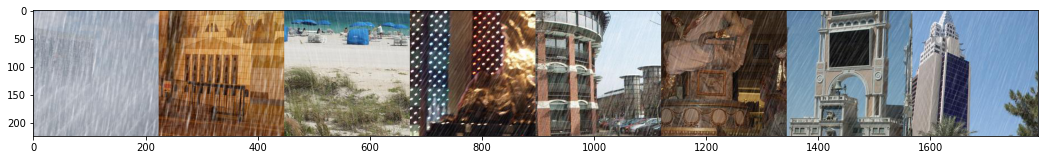

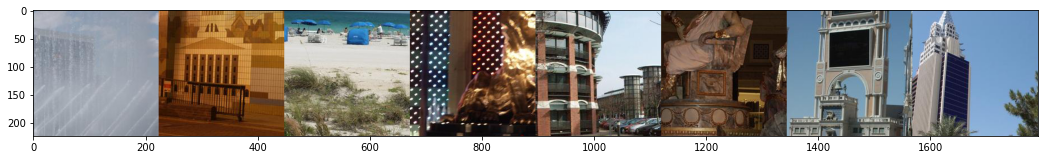

In [15]:
# Examine training data
%pylab inline
import torchvision
sample = iter(train_loader).next()
figure(figsize=(18,9))
imshow(torchvision.utils.make_grid(sample['input'], padding=0).permute((1, 2, 0)))

figure(figsize=(18,9))
imshow(torchvision.utils.make_grid(sample['target'].float(), padding=0).permute((1, 2, 0)))
#sample['target']

In [16]:
sample['target'].shape

torch.Size([8, 3, 224, 224])

In [17]:
loss_fn = nn.MSELoss()

In [18]:
METADATA = '/home/makam0a/Dropbox/projects/denoising/seismic/metadata/'

In [12]:
epochs = 30
learning_rate = 5e-5

run_id = 'model_gpu_n{}_bs{}_lr{}_pretrained'.format(epochs, batch_size, learning_rate); print('\n\nTraining', run_id)
save_path = os.path.join(METADATA, run_id + '.pkl')

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

class RMSE(object):
    def __init__(self):
        self.sq_errors = []
        self.num_pix = 0
        
    def get(self):
        return np.sqrt(
                    np.sum(np.array(self.sq_errors))/self.num_pix
                )
    
    def add_batch(self, pred, target):
        sqe = (pred-target)**2
        self.sq_errors.append(np.sum(sqe))
        self.num_pix += target.size
        
    def reset(self):
        self.sq_errors = []
        self.num_pix = 0


# Used to keep track of statistics
class AverageMeter(object):
    def __init__(self):
        self.val = 0; self.avg = 0; self.sum = 0; self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

REPORTS_PER_EPOCH = 10
ITER_PER_EPOCH = len(train_loader)
ITER_PER_REPORT = ITER_PER_EPOCH//REPORTS_PER_EPOCH

metrics = RMSE()

iteration_losses = []
iteration_avg_rmse = []

for epoch in range(epochs):
    model.train()
    
    # Progress reporting
    batch_time = AverageMeter()
    losses = AverageMeter()
    N = len(train_loader)
    end = time.time()

    for i, (sample) in enumerate(train_loader):

        # Load a batch and send it to GPU
        x = sample['input'].cuda()
        y = sample['target'].cuda()

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        
        # Record loss
        losses.update(loss.data.item(), x.size(0))

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model).
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
        
        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        eta = str(datetime.timedelta(seconds=int(batch_time.val*(N - i))))

        # Log training progress
        if i % ITER_PER_REPORT == 0:
            print('\nEpoch: [{0}][{1}/{2}]\t' 'Time {batch_time.val:.3f} ({batch_time.sum:.3f})\t' 'ETA {eta}\t'
             'Training Loss {loss.val:.4f} ({loss.avg:.4f})'.format(epoch, i, N, batch_time=batch_time, loss=losses, eta=eta))
        elif i % (ITER_PER_REPORT//50) == 0:
            print('.', end='')
            
        #break # useful for quick debugging        
    torch.cuda.empty_cache(); del x, y; 
    
    # Validation after each epoch
    model.eval()
    metrics.reset()
    for i, (sample) in enumerate(valid_loader):
        x, y = sample['input'].float().cuda(), sample['target'].numpy()
        with torch.no_grad():
            y_pred = model(x).detach().cpu().numpy()

        metrics.add_batch(y_pred, y)
        print('_', end='')
    print('\nValidation RMSE {avg_rmse}'.format(avg_rmse=metrics.get()))    
    iteration_losses.append(losses.avg)
    iteration_avg_rmse.append(metrics.get())

# Save model
torch.save(model.state_dict(), save_path)
print('\nTraining done. Model saved ({}).'.format(save_path))



Training model_gpu_n30_bs8_lr5e-05_pretrained

Epoch: [0][0/1543]	Time 1.059 (1.059)	ETA 0:27:13	Training Loss 0.5712 (0.5712)
...................................................
Epoch: [0][154/1543]	Time 0.106 (24.344)	ETA 0:02:26	Training Loss 0.0553 (0.0706)
...................................................
Epoch: [0][308/1543]	Time 0.101 (47.250)	ETA 0:02:04	Training Loss 0.0174 (0.0474)
...................................................
Epoch: [0][462/1543]	Time 0.365 (72.831)	ETA 0:06:34	Training Loss 0.0129 (0.0374)
...................................................
Epoch: [0][616/1543]	Time 0.107 (97.604)	ETA 0:01:38	Training Loss 0.0098 (0.0315)
...................................................
Epoch: [0][770/1543]	Time 0.103 (120.606)	ETA 0:01:19	Training Loss 0.0095 (0.0277)
...................................................
Epoch: [0][924/1543]	Time 0.103 (142.703)	ETA 0:01:04	Training Loss 0.0065 (0.0250)
...................................................
Epoch: 

.____________________________________________________________________________________________________________________________________________________________________________
Validation RMSE 0.06663911423019318

Epoch: [5][0/1543]	Time 1.172 (1.172)	ETA 0:30:07	Training Loss 0.0051 (0.0051)
...................................................
Epoch: [5][154/1543]	Time 0.107 (26.810)	ETA 0:02:28	Training Loss 0.0040 (0.0046)
...................................................
Epoch: [5][308/1543]	Time 0.234 (50.354)	ETA 0:04:49	Training Loss 0.0043 (0.0047)
...................................................
Epoch: [5][462/1543]	Time 0.092 (74.808)	ETA 0:01:39	Training Loss 0.0044 (0.0046)
...................................................
Epoch: [5][616/1543]	Time 0.104 (99.389)	ETA 0:01:36	Training Loss 0.0064 (0.0046)
...................................................
Epoch: [5][770/1543]	Time 0.104 (123.851)	ETA 0:01:20	Training Loss 0.0037 (0.0046)
.................................

.____________________________________________________________________________________________________________________________________________________________________________
Validation RMSE 0.05843522271041312

Epoch: [10][0/1543]	Time 0.919 (0.919)	ETA 0:23:37	Training Loss 0.0027 (0.0027)
...................................................
Epoch: [10][154/1543]	Time 0.104 (27.693)	ETA 0:02:24	Training Loss 0.0029 (0.0037)
...................................................
Epoch: [10][308/1543]	Time 0.103 (52.031)	ETA 0:02:06	Training Loss 0.0043 (0.0037)
...................................................
Epoch: [10][462/1543]	Time 0.287 (74.816)	ETA 0:05:09	Training Loss 0.0072 (0.0038)
...................................................
Epoch: [10][616/1543]	Time 0.244 (97.701)	ETA 0:03:46	Training Loss 0.0040 (0.0037)
...................................................
Epoch: [10][770/1543]	Time 0.105 (122.831)	ETA 0:01:20	Training Loss 0.0039 (0.0037)
...........................

...................................................
Epoch: [14][1540/1543]	Time 0.103 (243.787)	ETA 0:00:00	Training Loss 0.0051 (0.0033)
.____________________________________________________________________________________________________________________________________________________________________________
Validation RMSE 0.05763382252077359

Epoch: [15][0/1543]	Time 0.985 (0.985)	ETA 0:25:19	Training Loss 0.0065 (0.0065)
...................................................
Epoch: [15][154/1543]	Time 0.104 (24.082)	ETA 0:02:24	Training Loss 0.0059 (0.0033)
...................................................
Epoch: [15][308/1543]	Time 0.253 (46.825)	ETA 0:05:12	Training Loss 0.0017 (0.0033)
...................................................
Epoch: [15][462/1543]	Time 0.285 (71.716)	ETA 0:05:08	Training Loss 0.0030 (0.0033)
...................................................
Epoch: [15][616/1543]	Time 0.124 (96.828)	ETA 0:01:54	Training Loss 0.0050 (0.0032)
..........................

KeyboardInterrupt: 

In [15]:
save_path = os.path.join(METADATA, run_id + '.pkl')

In [16]:
torch.save(model.state_dict(), save_path)

In [19]:
# Validation after each epoch
model.eval()
metrics.reset()
for i, (sample) in enumerate(valid_loader):
    x, y = sample['input'].float().cuda(), sample['target'].numpy()
    with torch.no_grad():
        y_pred = model(x).detach().cpu().numpy()

    metrics.add_batch(y_pred, y)
    print('_', end='')
print('\nValidation RMSE {avg_rmse}'.format(avg_rmse=metrics.get()))    
iteration_losses.append(losses.avg)
iteration_avg_rmse.append(metrics.get())
#scheduler.step()

NameError: name 'metrics' is not defined

In [29]:
# Load model from disk
#model = create_model_gpu()
#model.load_state_dict(torch.load('model_gpu[0]_n10_bs8_lr0.0001.pkl'))
model.eval() # set to evaluation mode

# Visualize validation sample
sample = iter(valid_loader).next()
x = sample['input'].cuda()
y_pred, y = model(x), sample['target']

figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(sample['input'], padding=0).permute((1, 2, 0)))
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(sample['target'], padding=0, normalize=True, scale_each=True).permute((1, 2, 0)))
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(y_pred.detach().cpu(), padding=0, normalize=True, scale_each=True).permute((1, 2, 0)))

RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[8, 1, 224, 224] to have 3 channels, but got 1 channels instead

In [66]:
model = build_model('unet','firstbreak')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model, (1, 224, 224), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             288
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]           9,216
       BatchNorm2d-5         [-1, 32, 224, 224]              64
              ReLU-6         [-1, 32, 224, 224]               0
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,432
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
           Conv2d-11         [-1, 64, 112, 112]          36,864
      BatchNorm2d-12         [-1, 64, 112, 112]             128
             ReLU-13         [-1, 64, 112, 112]               0
        MaxPool2d-14           [-1, 64,

Using cache found in /home/makam0a/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [67]:
from data import get_train_val_dataset, get_dataset
firstbreak_dataset = get_dataset('firstbreak')

In [68]:
batch_size=8
workers=4
train_dataset, val_dataset = get_train_val_dataset(firstbreak_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)
print('Dataset size (num. batches)', len(train_loader), len(valid_loader))

Dataset size (num. batches) 239 27


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


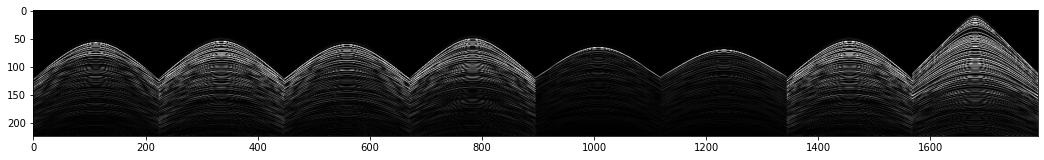

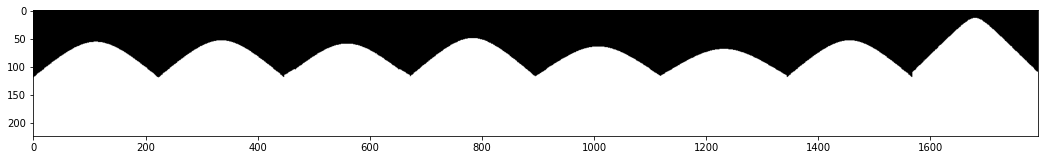

In [69]:
# Examine training data
%pylab inline
import torchvision
sample = iter(train_loader).next()
figure(figsize=(18,9))
imshow(torchvision.utils.make_grid(sample['input'], padding=0).permute((1, 2, 0)))

figure(figsize=(18,9))
imshow(torchvision.utils.make_grid(sample['target'].float().unsqueeze(1), padding=0).permute((1, 2, 0)))
#sample['target']

In [70]:
from metrics import Metrics
loss_fn = nn.CrossEntropyLoss()

In [71]:
epochs = 5
learning_rate = 5e-5

run_id = 'seg_model_gpu_n{}_bs{}_lr{}_scratch'.format(epochs, batch_size, learning_rate); print('\n\nTraining', run_id)
save_path = run_id + '.pkl'

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

metrics = Metrics(2, train_loader.dataset.dataset.class_names)

# Used to keep track of statistics
class AverageMeter(object):
    def __init__(self):
        self.val = 0; self.avg = 0; self.sum = 0; self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

REPORTS_PER_EPOCH = 10
ITER_PER_EPOCH = len(train_loader)
ITER_PER_REPORT = ITER_PER_EPOCH//REPORTS_PER_EPOCH


for epoch in range(epochs):
    model.train()

    # Progress reporting
    batch_time = AverageMeter()
    losses = AverageMeter()
    N = len(train_loader)
    end = time.time()

    for i, (sample) in enumerate(train_loader):

        # Load a batch and send it to GPU
        x = sample['input'].cuda()
        y = sample['target'].cuda()

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)

        # Record loss
        losses.update(loss.data.item(), x.size(0))

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model).
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        eta = str(datetime.timedelta(seconds=int(batch_time.val*(N - i))))

        # Log training progress
        if i % ITER_PER_REPORT == 0:
            print('\nEpoch: [{0}][{1}/{2}]\t' 'Time {batch_time.val:.3f} ({batch_time.sum:.3f})\t' 'ETA {eta}\t'
             'Training Loss {loss.val:.4f} ({loss.avg:.4f})'.format(epoch, i, N, batch_time=batch_time, loss=losses, eta=eta))
        elif i % (ITER_PER_REPORT) == 0:
            print('.', end='')

        #break # useful for quick debugging
    torch.cuda.empty_cache(); del x, y;

    # Validation after each epoch
    model.eval()
    metrics.reset()
    for i, (sample) in enumerate(valid_loader):
        x, y = sample['input'].float().cuda(), sample['target'].numpy()
        with torch.no_grad():
            y_pred = model(x)
            y_pred = torch.argmax(y_pred, dim=1) # get the most likely prediction

        metrics.add_batch(y, y_pred.detach().cpu().numpy())
        print('_', end='')
    print('\nValidation stats ', metrics.get_table())


# Save model
torch.save(model.state_dict(), save_path)
print('\nTraining done. Model saved ({}).'.format(save_path))



Training seg_model_gpu_n5_bs8_lr5e-05_scratch

Epoch: [0][0/239]	Time 0.316 (0.316)	ETA 0:01:15	Training Loss 0.6748 (0.6748)

Epoch: [0][23/239]	Time 0.106 (2.633)	ETA 0:00:22	Training Loss 0.5933 (0.6341)

Epoch: [0][46/239]	Time 0.097 (4.921)	ETA 0:00:18	Training Loss 0.5415 (0.5988)

Epoch: [0][69/239]	Time 0.097 (7.190)	ETA 0:00:16	Training Loss 0.5253 (0.5772)

Epoch: [0][92/239]	Time 0.094 (9.462)	ETA 0:00:13	Training Loss 0.5153 (0.5634)

Epoch: [0][115/239]	Time 0.097 (11.721)	ETA 0:00:12	Training Loss 0.5146 (0.5536)

Epoch: [0][138/239]	Time 0.097 (13.993)	ETA 0:00:09	Training Loss 0.5042 (0.5460)

Epoch: [0][161/239]	Time 0.097 (16.270)	ETA 0:00:07	Training Loss 0.5008 (0.5400)

Epoch: [0][184/239]	Time 0.097 (18.550)	ETA 0:00:05	Training Loss 0.4973 (0.5349)

Epoch: [0][207/239]	Time 0.096 (20.832)	ETA 0:00:03	Training Loss 0.4939 (0.5306)

Epoch: [0][230/239]	Time 0.097 (23.114)	ETA 0:00:00	Training Loss 0.4919 (0.5267)
___________________________
Validation stats      

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


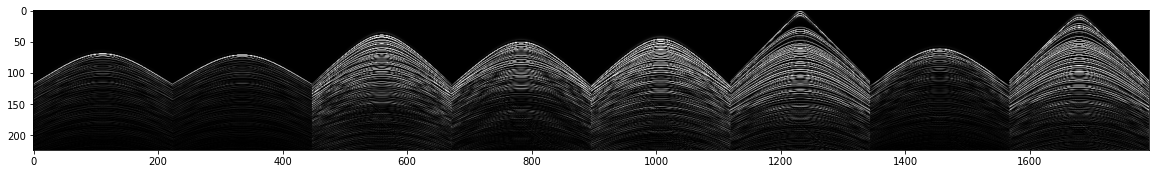

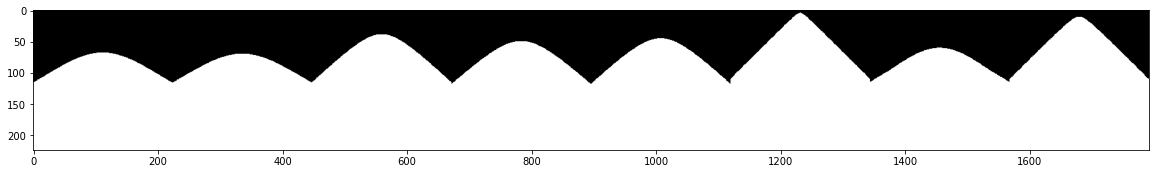

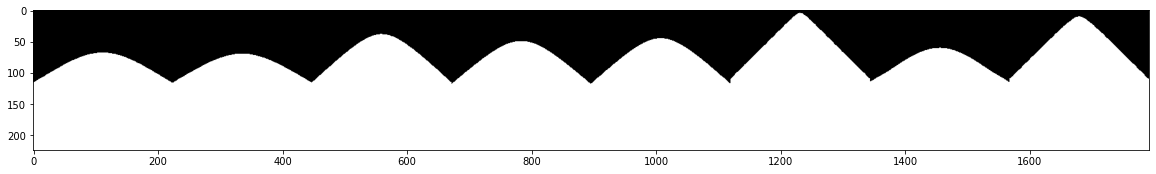

In [95]:
model.eval() # set to evaluation mode

# Visualize validation sample
sample = iter(valid_loader).next()
x = sample['input'].cuda()
y_pred, y = model(x), sample['target']

figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(sample['input'], padding=0).permute((1, 2, 0)))
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(sample['target'].float().unsqueeze(1), padding=0).permute((1, 2, 0)))
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(y_pred.argmax(dim=1).detach().cpu().float().unsqueeze(1), padding=0).permute((1, 2, 0)))

'10.2'